In [77]:
import pandas as pd
import seaborn as sns
import spacy # Dutch language package required (python -m spacy download nl_core_news_lg)
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [78]:
df = pd.read_excel('dataset.xlsx')

In [79]:
df = df.dropna(axis=1, how='all')
df.head()
TBT = df[(df['INTERFACEUSED'] == 'TBT') & (df['TURNTYPE'] == 'TBT')]
WYS = df[df['INTERFACEUSED'] == 'WYSIWYG']
test = WYS[(WYS['dyadid'] == 4) & (WYS['GameNo'] == 0)]

In [80]:
temp_string1, temp_string2 = '', ''
WYS_turn_list, participant1, participant2, time_lengths = [], [], [], []
timestamps = set()
gameid = WYS.iloc[0].GameNo
for index, row in WYS.iterrows():
    if gameid != row.GameNo:
        WYS_turn_list.append(([turn for turn in participant1 if turn != '' and turn != 'CORRECT' and turn != ' '], [turn for turn in participant2 if turn != '' and turn != 'CORRECT' and turn != ' ']))
        time_lengths.append((max(timestamps) - min(timestamps))/1000)
        participant1, participant2, timestamps = [],[],set()  
        gameid = row.GameNo
    timestamps.add(row.TimestampReceived)
    item = str(row.Text)
    if row.Sender == 'Participant1':
        if len(item) == 1:
            temp_string1 += item
        elif len(temp_string1) != 0 and len(item) != 0:
            participant1.append(temp_string1)
            participant1.append(item)
            temp_string1 = ''
        else:
            participant1.append(item)
    else:
        if len(item) == 1:
            temp_string2 += item
        elif len(temp_string2) != 0 and len(item) != 0:
            participant2.append(temp_string2)
            participant2.append(item)
            temp_string2 = ''
        else:
            participant2.append(item)
WYS_turn_list.append(([turn for turn in participant1 if turn != '' and turn != 'CORRECT'], [turn for turn in participant2 if turn != '' and turn != 'CORRECT']))
time_lengths.append((max(timestamps) - min(timestamps))/1000)


In [81]:
TBT_turn_list, participant1, participant2 = [], [], []
timestamps = set()
gameid = TBT.iloc[0].GameNo
for index, row in TBT.iterrows():
    if gameid != row.GameNo:
        TBT_turn_list.append(([turn for turn in participant1 if turn != '' and turn != 'CORRECT'], [turn for turn in participant2 if turn != '' and turn != 'CORRECT']))
        time_lengths.append((max(timestamps) - min(timestamps))/1000)
        participant1, participant2, timestamps = [],[], set()
        gameid = row.GameNo
    item = str(row.Text).strip()
    timestamps.add(row.TimestampReceived)
    if row.Sender == 'Participant1':
        participant1.append(item)
    else:
        participant2.append(item)
TBT_turn_list.append(([turn for turn in participant1 if turn != '' and turn != 'CORRECT'], [turn for turn in participant2 if turn != '' and turn != 'CORRECT']))
time_lengths.append((max(timestamps) - min(timestamps))/1000)


In [82]:
# Q1: Calculate the average number of turns per interface (efficiency)

In [83]:
length_WYS = 0
all_lengths_WYS = []
ratios_WYS = []
for conversation in WYS_turn_list:
    length_WYS += len(conversation[0]) + len(conversation[1])
    try:
        log_odds = math.log(len(conversation[0])/len(conversation[1]))
        ratios_WYS.append(log_odds)
    except ZeroDivisionError:
        pass
    all_lengths_WYS.append([len(conversation[0]) + len(conversation[1]), log_odds, 'WYS'])

print('The average length of a WYSIWYG conversation is {0:.0f} turns'.format(length_WYS/len(WYS_turn_list)))

length_TBT = 0
all_lengths_TBT = []
ratios_TBT = []
for conversation in TBT_turn_list:
    length_TBT += len(conversation[0]) + len(conversation[1])
    try:
        log_odds = math.log(len(conversation[0])/len(conversation[1]))
        ratios_TBT.append(log_odds)
    except ZeroDivisionError:
        pass
    all_lengths_TBT.append([len(conversation[0]) + len(conversation[1]), log_odds, 'TBT'])

print('The average length of a TBT conversation is {0:.0f} turns'.format(length_TBT/len(TBT_turn_list)))
    

The average length of a WYSIWYG conversation is 50 turns
The average length of a TBT conversation is 24 turns


In [84]:
interface_df = pd.DataFrame(all_lengths_WYS + all_lengths_TBT, columns=['Length', 'LogOdds', 'Interface'])

<AxesSubplot:xlabel='Interface', ylabel='Length'>

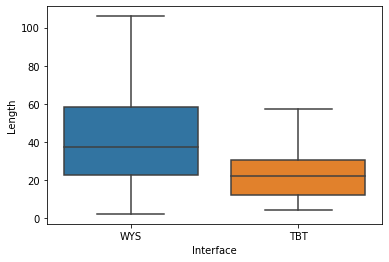

In [85]:
sns.boxplot(x=interface_df['Interface'], y=interface_df['Length'], showfliers=False)

In [86]:
# Q2: Calculate ratios of turn by participant1 to participant2 (Turn taking)

In [87]:
print(sum(ratios_TBT)/len(ratios_TBT))
print(sum(ratios_WYS)/len(ratios_WYS))

0.042134187051223404
0.04182711905735217


<AxesSubplot:xlabel='Interface', ylabel='LogOdds'>

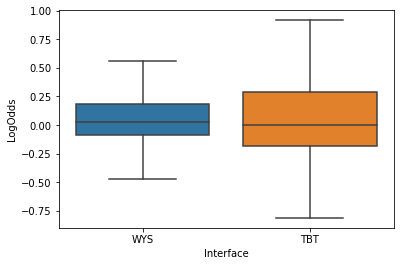

In [88]:
sns.boxplot(x=interface_df['Interface'], y=interface_df['LogOdds'], showfliers=False)

In [89]:
# Q3: Calculate similarity of the conversations

In [90]:
nlp = spacy.load('nl_core_news_lg')

In [91]:
sentiment = SentimentIntensityAnalyzer()

In [92]:
TBT_similarity_scores, WYS_similarity_scores, TBT_sentiment_scores, WYS_sentiment_scores, TBT_synchrony_scores, WYS_synchrony_scores = [],[],[],[],[],[]
for i in range(len(TBT_turn_list)):
    convo1 = nlp(' '.join(TBT_turn_list[i][0]))
    convo2 = nlp(' '.join(TBT_turn_list[i][1]))
    sentiment1 = sentiment.polarity_scores(' '.join(TBT_turn_list[i][0]))
    sentiment2 = sentiment.polarity_scores(' '.join(TBT_turn_list[i][1]))
    TBT_similarity_scores.append(convo1.similarity(convo2))
    TBT_sentiment_scores.append((sentiment1['pos']+sentiment2['pos'])/2)
    TBT_synchrony_scores.append(abs(sentiment1['neg']-sentiment2['neg']) + abs(sentiment1['neu']-sentiment2['neu']) + abs(sentiment1['pos']-sentiment2['pos']))
    
for i in range(len(WYS_turn_list)):
    convo1 = nlp(' '.join(WYS_turn_list[i][0]))
    convo2 = nlp(' '.join(WYS_turn_list[i][1]))
    sentiment1 = sentiment.polarity_scores(' '.join(WYS_turn_list[i][0]))
    sentiment2 = sentiment.polarity_scores(' '.join(WYS_turn_list[i][1]))
    WYS_similarity_scores.append(convo1.similarity(convo2))
    WYS_sentiment_scores.append((sentiment1['pos']+sentiment2['pos'])/2)
    WYS_synchrony_scores.append(abs(sentiment1['neg']-sentiment2['neg']) + abs(sentiment1['neu']-sentiment2['neu']) + abs(sentiment1['pos']-sentiment2['pos']))

<ipython-input-92-f08e239d16a8>:16: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  WYS_similarity_scores.append(convo1.similarity(convo2))


In [93]:
interface_df['Similarity'] = (WYS_similarity_scores+TBT_similarity_scores)
interface_df['Happiness'] = (WYS_sentiment_scores+TBT_sentiment_scores)
interface_df['Synchrony'] = (WYS_synchrony_scores+TBT_synchrony_scores)
interface_df['Time'] = (time_lengths)

<AxesSubplot:xlabel='Interface', ylabel='Similarity'>

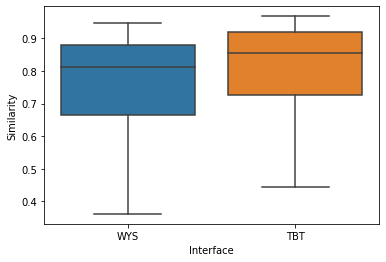

In [94]:
sns.boxplot(x=interface_df['Interface'], y=interface_df['Similarity'], showfliers=False)

<AxesSubplot:xlabel='Interface', ylabel='Happiness'>

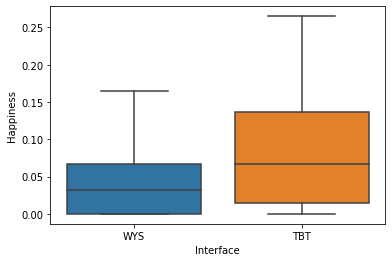

In [95]:
sns.boxplot(x=interface_df['Interface'], y=interface_df['Happiness'], showfliers=False)

<AxesSubplot:xlabel='Interface', ylabel='Synchrony'>

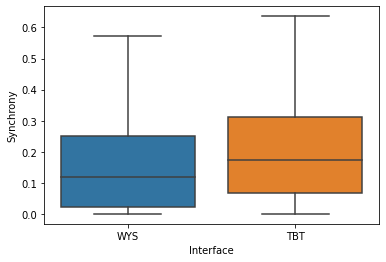

In [96]:
sns.boxplot(x=interface_df['Interface'], y=interface_df['Synchrony'], showfliers=False)

<AxesSubplot:xlabel='Interface', ylabel='Time'>

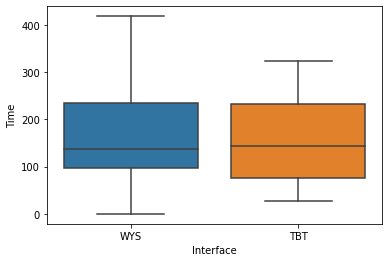

In [97]:
sns.boxplot(x=interface_df['Interface'], y=interface_df['Time'], showfliers=False)